In [1]:
%matplotlib notebook
import numpy as np
from numpy import random
import scipy as sp
from prosstt import simulation as sim
from prosstt import tree
from prosstt.tree import Tree

import matplotlib.pyplot as plt

In [2]:
lineage = Tree.from_topology(Tree.gen_random_topology(1))

In [3]:
print(lineage.topology)
print(lineage.time)

[[0, 1], [0, 2]]
[40, 40, 40]


In [4]:
np.sum(lineage.default_density())

0.99999999999999989

In [5]:
# first half, going up to the branch point
# half a normal distribution, so we half the PDF
mmin = -4
mmax = 0
steps = 40
step_size = np.abs(mmax - mmin) / steps
pos = np.arange(mmin, mmax, step_size)
len(pos)
mynorm = sp.stats.norm()
branch0 = mynorm.pdf(pos) / 2
# second half, going down from the branch point
# two times since we want it for both new branches
mmin = 0
mmax = 4
steps = 40
step_size = np.abs(mmax - mmin) / steps
pos = np.arange(mmin, mmax, step_size)
branch12 = mynorm.pdf(pos) / 4

In [6]:
# use densities and normalize to make sure it adds up to 1
# so that the probabilistic sampling makes sense
density = np.array([branch0, branch12, branch12])
lineage.density = density / np.sum(density)

In [7]:
alpha = np.exp(random.normal(loc=np.log(0.2), scale=0.3, size=lineage.G))
beta = np.exp(1 + random.normal(loc=np.log(2), scale=0.3, size=lineage.G))

Ms = None
while not sim.are_lengths_ok(Ms, abs_max=1000, rel_dif=0.05):
    uMs, Ws, Hs = sim.simulate_branching_data(lineage, tol=0.2)
    gene_scale = np.exp(sp.stats.norm.rvs(loc=0.8, scale=1, size=lineage.G))
    Ms = [np.zeros((lineage.time[i], lineage.G)) for i in range(3)]
    for i in range(3):
        Ms[i] = np.exp(uMs[i]) * gene_scale

lineage.add_genes(Ms)

/home/npapado/miniconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [8]:
X, labels, branches, scalings = sim.sample_density(lineage, 500, alpha=alpha, beta=beta)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 99.8% 

<IPython.core.display.Javascript object>


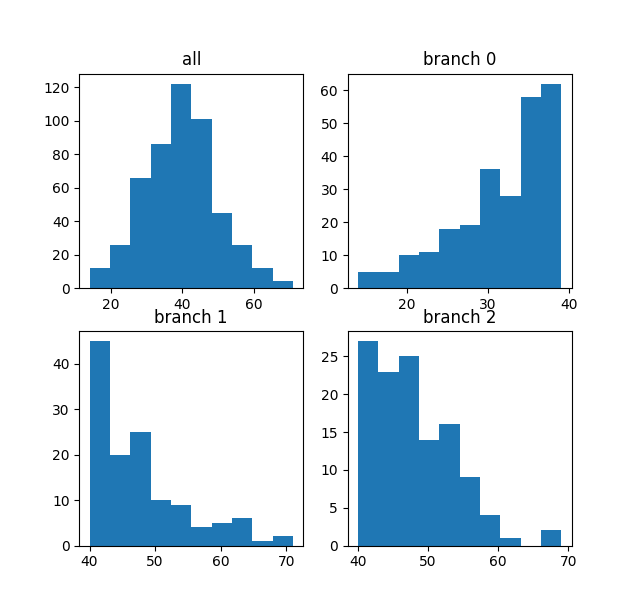

Text(0.5,1,'branch 2')

In [17]:
# test if it worked
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0, 0].hist(labels)
ax[0, 0].set_title("all")
ax[0, 1].hist(labels[branches==0])
ax[0, 1].set_title("branch 0")
ax[1, 0].hist(labels[branches==1])
ax[1, 0].set_title("branch 1")
ax[1, 1].hist(labels[branches==2])
ax[1, 1].set_title("branch 2")